In [3]:
import torch
import laplace
import numpy as np
import torch.utils
import matplotlib.pyplot as plt
from main.models import ConvNet
from main.training_models import train_model
from batchbald_redux import repeated_mnist, joint_entropy, batchbald
from laplace.marglik_training import marglik_training
from laplace.curvature import AsdlGGN

%reload_ext autoreload
%autoreload 2

c:\Users\vince\Documents\Statistics\TT\msc_thesis\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [167]:
# load mnist data
train_dataset, val_dataset = repeated_mnist.create_MNIST_dataset()

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32,
                                           sampler=torch.utils.data.SubsetRandomSampler(range(1000)))
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, sampler=torch.utils.data.SubsetRandomSampler(range(1000)))

# collapse data from training_loader into tensor for x and y
x = torch.cat([x for x, y in train_loader], dim=0)
y = torch.cat([y for x, y in train_loader], dim=0)

x_test, y_test = next(iter(val_loader))

In [168]:
# train model and jointly optimize for marginal likelihood
model = ConvNet()

# train model
train_model(model, train_loader, num_epochs=20)

Epoch 1/20, Loss: 1.5452349185943604
Epoch 6/20, Loss: 0.014668868854641914
Epoch 11/20, Loss: 0.18554271757602692
Epoch 16/20, Loss: 0.0007303844322450459


ConvNet(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): GELU(approximate='none')
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (4): GELU(approximate='none')
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Sequential(
    (0): Linear(in_features=512, out_features=32, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=32, out_features=10, bias=True)
  )
  (_last_layer): Linear(in_features=32, out_features=10, bias=True)
)

In [169]:
# check accuracy
correct = 0
total = 0

with torch.no_grad():
    for data in val_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 1000 test images: %d %%' % ( 100 * correct / total))

Accuracy of the network on the 1000 test images: 93 %


In [274]:
la = laplace.Laplace(model,
                     likelihood="classification",
                     subset_of_weights='last_layer',
                     hessian_structure='kron',
                     backend=AsdlGGN
                     )
la.fit(train_loader=train_loader)
la.optimize_prior_precision(method='marglik', verbose=True)

c:\Users\vince\Documents\Statistics\TT\msc_thesis\.venv\Lib\site-packages\torch\nn\modules\module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Optimized prior precision is tensor([4.5990]).


c:\Users\vince\Documents\Statistics\TT\msc_thesis\.venv\Lib\site-packages\laplace\baselaplace.py:409: UserWarning: By default `link_approx` is `probit`. Make sure to set it equals to the way you want to call `la(test_data, pred_type=..., link_approx=...)`.
  warnings.warn(


Dimension of $\theta$ is 330 (32*10 + 10) 

Dimension of predicted $Y_1, \dots Y_N$ is $N * C = 32*10$

So total dimension should be 330 + 320 = 650.

In [363]:
from main.bald_sampling import compute_joint_eig, compute_joint_entropy, compute_normal_entropy
K = 10000
ent, probs, cov = compute_joint_entropy(la, x_test, K=K)

KeyboardInterrupt: 

In [366]:
shrunken_cov = cov + 1e-3 * torch.eye(cov.shape[0])

In [367]:
rnk = torch.linalg.matrix_rank(shrunken_cov)
lin_dep = len(cov) - torch.linalg.matrix_rank(shrunken_cov)
print(f"Rank of covariance matrix: {rnk}")
print(f"Linearly dependent columns: {lin_dep}")

Rank of covariance matrix: 650
Linearly dependent columns: 0


In [368]:
eigvals = torch.linalg.eigvalsh(cov)
eigvals.min(), eigvals.max(), eigvals.mean(), eigvals.median()

(tensor(-5.8878e-08), tensor(1.1311), tensor(0.1415), tensor(0.1518))

In [369]:
cov_theta = cov[320:, 320:]
cov_p = cov[:320, :320]

Text(0.5, 1.0, 'Covariance of y (10 classes, 32 data points)')

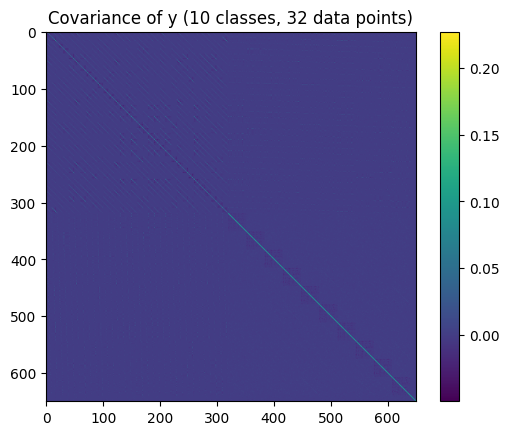

In [371]:
plt.imshow(shrunken_cov)
plt.colorbar()
plt.title('Covariance of y (10 classes, 32 data points)')